In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# Parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
display_step = 1

C:\___Anaconda\envs\forTFgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\___Anaconda\envs\forTFgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\___Anaconda\envs\forTFgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\___Anaconda\envs\forTFgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [ ]:
with tf.device('/gpu:0'):
    X = tf.placeholder(tf.float32, [None, 784])
    X_img = tf.reshape(X, [-1, 28, 28, 1]) # img 28x28x1 (black/white)
    Y = tf.placeholder(tf.float32, [None, 10])
    keep_prob = tf.placeholder(tf.float32)


    # L1 ImgIn shape=(?, 28, 28, 1)
    W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
    L1 = tf.nn.conv2d(X_img, W1, strides=[1,1,1,1], padding='SAME')
    L1 = tf.nn.relu(L1)
    L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
    #    Conv    -> (?, 28, 28, 32)
    #    Pool    -> (?, 14, 14, 32)


    # L2 ImgIn shape=(?, 14, 14, 32)
    W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
    L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding='SAME')
    L2 = tf.nn.relu(L2)
    L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
    #    Conv    -> (?, 14, 14, 64)
    #    Pool    -> (?, 7, 7, 64)
    
    
    # L3 ImgIn shape=(?, 7, 7, 64)
    W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
    L3 = tf.nn.conv2d(L2, W3, strides=[1,1,1,1], padding='SAME')
    L3 = tf.nn.relu(L3)
    L3 = tf.nn.max_pool(L3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
    L3 = tf.reshape(L3, [-1, 4*4*128])
    #    Conv    -> (?, 7, 7, 128)
    #    Pool    -> (?, 4, 4, 128)
    #    reshape -> (?, 2048)


    # L4 ImgIn shape=(?, 2048)
    W4 = tf.get_variable('W4', shape=[4*4*128, 625], initializer=tf.contrib.layers.xavier_initializer())
    b4 = tf.Variable(tf.random_normal([625]))
    L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
    L4 = tf.nn.dropout(L4, keep_prob=keep_prob)
    
    
    W5 = tf.get_variable('W5', shape=[625, 10], initializer=tf.contrib.layers.xavier_initializer())
    b5 = tf.Variable(tf.random_normal([10]))
    hypothesis = tf.matmul(L4, W5) + b5


    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
# Training
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())
#sess.run(tf.initialize_all_variables())

# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        #feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)

        avg_cost += c / total_batch #뭉치갯수로 나누기


    print('Epoch : ', '%04d' % (epoch + 1), 'cost = ', '{:.9f}'.format(avg_cost))


Epoch :  0001 cost =  0.352162507
Epoch :  0002 cost =  0.098252507
Epoch :  0003 cost =  0.072226447
Epoch :  0004 cost =  0.060091615
Epoch :  0005 cost =  0.052744024
Epoch :  0006 cost =  0.047078775
Epoch :  0007 cost =  0.043012008


Accuracy :  0.9864
Label: [2]
Prediction: [2]


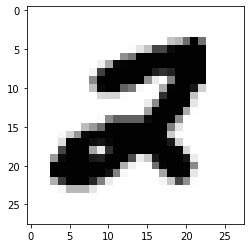

In [ ]:
# TEST
is_correct = tf.equal(tf.arg_max(hypothesis, 1), tf.arg_max(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

feed_dict = {X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}
#feed_dict = {X: mnist.test.images, Y: mnist.test.labels}
print("Accuracy : ", accuracy.eval(session=sess, feed_dict=feed_dict))

r = random.randint(0, mnist.test.num_examples - 1)
print('Label:', sess.run(tf.argmax(mnist.test.labels[r:r+1], 1)))

feed_dict = {X: mnist.test.images[r:r+1], keep_prob: 1}
#feed_dict = {X: mnist.test.images[r:r+1]}
print('Prediction:', sess.run(tf.argmax(hypothesis, 1), feed_dict=feed_dict))

plt.imshow(mnist.test.images[r:r+1].reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

In [ ]:
tf.__version__

'1.14.0'